## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

--2020-05-03 11:18:06--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.30.30
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.30.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip’

train-test-data.zip 100%[===================>] 322.93M  63.5MB/s    in 5.1s    

2020-05-03 11:18:12 (63.0 MB/s) - ‘/data/train-test-data.zip’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip
   creating: /data/test/
  inflating: /data/test/Abdel_Aziz_Al-Hakim_00.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_01.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_10.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_11.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_40.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_41.jpg  
  inflating: /data/test/Abdullah_Gul_10.j

<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=136, bias=True)
  (dropout): Dropout(p=0.25)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from PIL import Image
import data_load
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop

data_transform = transforms.Compose([
        
        Rescale(250),
        RandomCrop(224),
        Normalize(),
        ToTensor()
        
       
])
    
# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)

print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples

for i in range(4):
    sample =transformed_dataset[i]
    
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=1)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

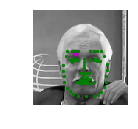

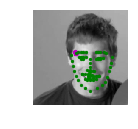

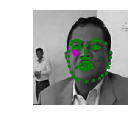

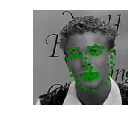

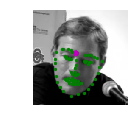

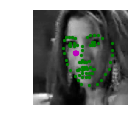

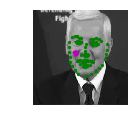

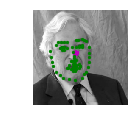

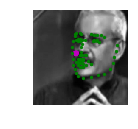

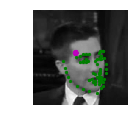

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer =optim.Adam(net.parameters(), lr=0.0001)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [15]:
# train your network
n_epochs =50# start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.2881151497364044
Epoch: 1, Batch: 20, Avg. Loss: 0.19364466667175292
Epoch: 1, Batch: 30, Avg. Loss: 0.13397208601236343
Epoch: 1, Batch: 40, Avg. Loss: 0.11836586818099022
Epoch: 1, Batch: 50, Avg. Loss: 0.12062624245882034
Epoch: 1, Batch: 60, Avg. Loss: 0.10183385498821736
Epoch: 1, Batch: 70, Avg. Loss: 0.10812407657504082
Epoch: 1, Batch: 80, Avg. Loss: 0.1176106758415699
Epoch: 1, Batch: 90, Avg. Loss: 0.11524117439985275
Epoch: 1, Batch: 100, Avg. Loss: 0.10756486356258392
Epoch: 1, Batch: 110, Avg. Loss: 0.0933780737221241
Epoch: 1, Batch: 120, Avg. Loss: 0.11041978970170022
Epoch: 1, Batch: 130, Avg. Loss: 0.08292930200695992
Epoch: 1, Batch: 140, Avg. Loss: 0.09026815555989742
Epoch: 1, Batch: 150, Avg. Loss: 0.10943438336253167
Epoch: 1, Batch: 160, Avg. Loss: 0.10391846671700478
Epoch: 1, Batch: 170, Avg. Loss: 0.11026976630091667
Epoch: 1, Batch: 180, Avg. Loss: 0.08743855506181716
Epoch: 1, Batch: 190, Avg. Loss: 0.08817654103040695
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.09629658572375774
Epoch: 2, Batch: 20, Avg. Loss: 0.10434018783271312
Epoch: 2, Batch: 30, Avg. Loss: 0.09205635190010071
Epoch: 2, Batch: 40, Avg. Loss: 0.0850845791399479
Epoch: 2, Batch: 50, Avg. Loss: 0.08156619183719158
Epoch: 2, Batch: 60, Avg. Loss: 0.08728640750050545
Epoch: 2, Batch: 70, Avg. Loss: 0.09076468162238598
Epoch: 2, Batch: 80, Avg. Loss: 0.0933701355010271
Epoch: 2, Batch: 90, Avg. Loss: 0.09071336053311825
Epoch: 2, Batch: 100, Avg. Loss: 0.08931070566177368
Epoch: 2, Batch: 110, Avg. Loss: 0.08618836924433708
Epoch: 2, Batch: 120, Avg. Loss: 0.08663931936025619
Epoch: 2, Batch: 130, Avg. Loss: 0.09370347186923027
Epoch: 2, Batch: 140, Avg. Loss: 0.08187337592244148
Epoch: 2, Batch: 150, Avg. Loss: 0.08719782829284668
Epoch: 2, Batch: 160, Avg. Loss: 0.08699804730713367
Epoch: 2, Batch: 170, Avg. Loss: 0.08194416761398315
Epoch: 2, Batch: 180, Avg. Loss: 0.08120804913341999
Epoch: 2, Batch: 190, Avg. Loss: 0.08760327845811844
Epoc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.06308951787650585
Epoch: 3, Batch: 20, Avg. Loss: 0.0815342515707016
Epoch: 3, Batch: 30, Avg. Loss: 0.06284758485853673
Epoch: 3, Batch: 40, Avg. Loss: 0.07902214191854
Epoch: 3, Batch: 50, Avg. Loss: 0.07883508950471878
Epoch: 3, Batch: 60, Avg. Loss: 0.07380349449813366
Epoch: 3, Batch: 70, Avg. Loss: 0.07571696862578392
Epoch: 3, Batch: 80, Avg. Loss: 0.0716324009001255
Epoch: 3, Batch: 90, Avg. Loss: 0.09059262163937092
Epoch: 3, Batch: 100, Avg. Loss: 0.07776930928230286
Epoch: 3, Batch: 110, Avg. Loss: 0.08213457576930523
Epoch: 3, Batch: 120, Avg. Loss: 0.07294855006039143
Epoch: 3, Batch: 130, Avg. Loss: 0.06531277000904083
Epoch: 3, Batch: 140, Avg. Loss: 0.07221029475331306
Epoch: 3, Batch: 150, Avg. Loss: 0.07548824325203896
Epoch: 3, Batch: 160, Avg. Loss: 0.06838520802557468
Epoch: 3, Batch: 170, Avg. Loss: 0.06088091470301151
Epoch: 3, Batch: 180, Avg. Loss: 0.07578046768903732
Epoch: 3, Batch: 190, Avg. Loss: 0.06709713973104954
Epoch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.0763882588595152
Epoch: 4, Batch: 20, Avg. Loss: 0.07311708256602287
Epoch: 4, Batch: 30, Avg. Loss: 0.06701026521623135
Epoch: 4, Batch: 40, Avg. Loss: 0.06955573856830596
Epoch: 4, Batch: 50, Avg. Loss: 0.06387876756489277
Epoch: 4, Batch: 60, Avg. Loss: 0.06691997237503529
Epoch: 4, Batch: 70, Avg. Loss: 0.05642141662538051
Epoch: 4, Batch: 80, Avg. Loss: 0.053857868909835814
Epoch: 4, Batch: 90, Avg. Loss: 0.08876408897340297
Epoch: 4, Batch: 100, Avg. Loss: 0.06355126686394215
Epoch: 4, Batch: 110, Avg. Loss: 0.05460436530411243
Epoch: 4, Batch: 120, Avg. Loss: 0.05416473709046841
Epoch: 4, Batch: 130, Avg. Loss: 0.05039190519601107
Epoch: 4, Batch: 140, Avg. Loss: 0.062395719438791276
Epoch: 4, Batch: 150, Avg. Loss: 0.05466955751180649
Epoch: 4, Batch: 160, Avg. Loss: 0.0860063487663865
Epoch: 4, Batch: 170, Avg. Loss: 0.05578264184296131
Epoch: 4, Batch: 180, Avg. Loss: 0.05088313929736614
Epoch: 4, Batch: 190, Avg. Loss: 0.045190248638391495
E

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.0509815413504839
Epoch: 5, Batch: 20, Avg. Loss: 0.05332083310931921
Epoch: 5, Batch: 30, Avg. Loss: 0.04635832794010639
Epoch: 5, Batch: 40, Avg. Loss: 0.05695918463170528
Epoch: 5, Batch: 50, Avg. Loss: 0.04498078040778637
Epoch: 5, Batch: 60, Avg. Loss: 0.040277404524385926
Epoch: 5, Batch: 70, Avg. Loss: 0.05393868144601584
Epoch: 5, Batch: 80, Avg. Loss: 0.037620804831385614
Epoch: 5, Batch: 90, Avg. Loss: 0.06252848487347365
Epoch: 5, Batch: 100, Avg. Loss: 0.048451632261276245
Epoch: 5, Batch: 110, Avg. Loss: 0.04316045325249433
Epoch: 5, Batch: 120, Avg. Loss: 0.07238854877650738
Epoch: 5, Batch: 130, Avg. Loss: 0.040524540655314925
Epoch: 5, Batch: 140, Avg. Loss: 0.05021045003086329
Epoch: 5, Batch: 150, Avg. Loss: 0.051834609173238275
Epoch: 5, Batch: 160, Avg. Loss: 0.05203275810927153
Epoch: 5, Batch: 170, Avg. Loss: 0.050928468257188796
Epoch: 5, Batch: 180, Avg. Loss: 0.048281222209334375
Epoch: 5, Batch: 190, Avg. Loss: 0.04078220576047

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.039431807957589625
Epoch: 6, Batch: 20, Avg. Loss: 0.03932937607169151
Epoch: 6, Batch: 30, Avg. Loss: 0.02979343868792057
Epoch: 6, Batch: 40, Avg. Loss: 0.039950431510806086
Epoch: 6, Batch: 50, Avg. Loss: 0.03996413797140121
Epoch: 6, Batch: 60, Avg. Loss: 0.050921143032610416
Epoch: 6, Batch: 70, Avg. Loss: 0.03561434522271156
Epoch: 6, Batch: 80, Avg. Loss: 0.03916683085262775
Epoch: 6, Batch: 90, Avg. Loss: 0.026906623877584933
Epoch: 6, Batch: 100, Avg. Loss: 0.03777109105139971
Epoch: 6, Batch: 110, Avg. Loss: 0.047043079324066636
Epoch: 6, Batch: 120, Avg. Loss: 0.04098339360207319
Epoch: 6, Batch: 130, Avg. Loss: 0.03371115326881409
Epoch: 6, Batch: 140, Avg. Loss: 0.032904873974621295
Epoch: 6, Batch: 150, Avg. Loss: 0.04335172604769468
Epoch: 6, Batch: 160, Avg. Loss: 0.03507889024913311
Epoch: 6, Batch: 170, Avg. Loss: 0.0341037604957819
Epoch: 6, Batch: 180, Avg. Loss: 0.03287469744682312
Epoch: 6, Batch: 190, Avg. Loss: 0.032265756465494

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.03730824366211891
Epoch: 7, Batch: 20, Avg. Loss: 0.0294858580455184
Epoch: 7, Batch: 30, Avg. Loss: 0.030265722796320914
Epoch: 7, Batch: 40, Avg. Loss: 0.037576208263635634
Epoch: 7, Batch: 50, Avg. Loss: 0.03056405298411846
Epoch: 7, Batch: 60, Avg. Loss: 0.029466914013028145
Epoch: 7, Batch: 70, Avg. Loss: 0.03778177723288536
Epoch: 7, Batch: 80, Avg. Loss: 0.034692047722637655
Epoch: 7, Batch: 90, Avg. Loss: 0.03521714843809605
Epoch: 7, Batch: 100, Avg. Loss: 0.02565724402666092
Epoch: 7, Batch: 110, Avg. Loss: 0.02766752038151026
Epoch: 7, Batch: 120, Avg. Loss: 0.022446276899427176
Epoch: 7, Batch: 130, Avg. Loss: 0.029232758935540913
Epoch: 7, Batch: 140, Avg. Loss: 0.03675855463370681
Epoch: 7, Batch: 150, Avg. Loss: 0.03568483106791973
Epoch: 7, Batch: 160, Avg. Loss: 0.02598731480538845
Epoch: 7, Batch: 170, Avg. Loss: 0.025313241127878427
Epoch: 7, Batch: 180, Avg. Loss: 0.02278894353657961
Epoch: 7, Batch: 190, Avg. Loss: 0.05958386687561

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.026035678572952747
Epoch: 8, Batch: 20, Avg. Loss: 0.04186583627015352
Epoch: 8, Batch: 30, Avg. Loss: 0.024196460470557214
Epoch: 8, Batch: 40, Avg. Loss: 0.027023197244852783
Epoch: 8, Batch: 50, Avg. Loss: 0.02651919825002551
Epoch: 8, Batch: 60, Avg. Loss: 0.028010846488177775
Epoch: 8, Batch: 70, Avg. Loss: 0.04288492044433952
Epoch: 8, Batch: 80, Avg. Loss: 0.031844220031052826
Epoch: 8, Batch: 90, Avg. Loss: 0.027954893186688423
Epoch: 8, Batch: 100, Avg. Loss: 0.04125732202082873
Epoch: 8, Batch: 110, Avg. Loss: 0.023087725136429073
Epoch: 8, Batch: 120, Avg. Loss: 0.03647884503006935
Epoch: 8, Batch: 130, Avg. Loss: 0.031104751303792
Epoch: 8, Batch: 140, Avg. Loss: 0.01902071190997958
Epoch: 8, Batch: 150, Avg. Loss: 0.0460666524246335
Epoch: 8, Batch: 160, Avg. Loss: 0.02902928739786148
Epoch: 8, Batch: 170, Avg. Loss: 0.025857765600085257
Epoch: 8, Batch: 180, Avg. Loss: 0.02962123528122902
Epoch: 8, Batch: 190, Avg. Loss: 0.027598615176975

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.03371912185102701
Epoch: 9, Batch: 20, Avg. Loss: 0.02404880542308092
Epoch: 9, Batch: 30, Avg. Loss: 0.04171588141471148
Epoch: 9, Batch: 40, Avg. Loss: 0.0197052332572639
Epoch: 9, Batch: 50, Avg. Loss: 0.019743407797068357
Epoch: 9, Batch: 60, Avg. Loss: 0.02092267805710435
Epoch: 9, Batch: 70, Avg. Loss: 0.02779883807525039
Epoch: 9, Batch: 80, Avg. Loss: 0.018336808867752553
Epoch: 9, Batch: 90, Avg. Loss: 0.023148024454712868
Epoch: 9, Batch: 100, Avg. Loss: 0.036650200746953486
Epoch: 9, Batch: 110, Avg. Loss: 0.022377485036849977
Epoch: 9, Batch: 120, Avg. Loss: 0.029641051590442658
Epoch: 9, Batch: 130, Avg. Loss: 0.024463616032153367
Epoch: 9, Batch: 140, Avg. Loss: 0.02078676354140043
Epoch: 9, Batch: 150, Avg. Loss: 0.02111097499728203
Epoch: 9, Batch: 160, Avg. Loss: 0.03477917779237032
Epoch: 9, Batch: 170, Avg. Loss: 0.019193255063146352
Epoch: 9, Batch: 180, Avg. Loss: 0.02427008068189025
Epoch: 9, Batch: 190, Avg. Loss: 0.0277099333703

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.02226389404386282
Epoch: 10, Batch: 20, Avg. Loss: 0.018495067860931157
Epoch: 10, Batch: 30, Avg. Loss: 0.020703645423054695
Epoch: 10, Batch: 40, Avg. Loss: 0.01926438184455037
Epoch: 10, Batch: 50, Avg. Loss: 0.03819867428392172
Epoch: 10, Batch: 60, Avg. Loss: 0.026099324878305196
Epoch: 10, Batch: 70, Avg. Loss: 0.021023512817919254
Epoch: 10, Batch: 80, Avg. Loss: 0.02463001701980829
Epoch: 10, Batch: 90, Avg. Loss: 0.027018763404339553
Epoch: 10, Batch: 100, Avg. Loss: 0.023088841419667005
Epoch: 10, Batch: 110, Avg. Loss: 0.029327135346829892
Epoch: 10, Batch: 120, Avg. Loss: 0.016670608334243296
Epoch: 10, Batch: 130, Avg. Loss: 0.016927503887563942
Epoch: 10, Batch: 140, Avg. Loss: 0.020554419327527284
Epoch: 10, Batch: 150, Avg. Loss: 0.015821226593106984
Epoch: 10, Batch: 160, Avg. Loss: 0.025509817991405725
Epoch: 10, Batch: 170, Avg. Loss: 0.023474979028105736
Epoch: 10, Batch: 180, Avg. Loss: 0.02026107655838132
Epoch: 10, Batch: 190, A

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.020338842459023
Epoch: 11, Batch: 20, Avg. Loss: 0.018611508421599865
Epoch: 11, Batch: 30, Avg. Loss: 0.02220116648823023
Epoch: 11, Batch: 40, Avg. Loss: 0.03544480511918664
Epoch: 11, Batch: 50, Avg. Loss: 0.023854050505906343
Epoch: 11, Batch: 60, Avg. Loss: 0.027941964473575352
Epoch: 11, Batch: 70, Avg. Loss: 0.01621359307318926
Epoch: 11, Batch: 80, Avg. Loss: 0.022637911979109047
Epoch: 11, Batch: 90, Avg. Loss: 0.02003471916541457
Epoch: 11, Batch: 100, Avg. Loss: 0.018022343795746566
Epoch: 11, Batch: 110, Avg. Loss: 0.01910562738776207
Epoch: 11, Batch: 120, Avg. Loss: 0.02488023303449154
Epoch: 11, Batch: 130, Avg. Loss: 0.01782827591523528
Epoch: 11, Batch: 140, Avg. Loss: 0.014760729484260082
Epoch: 11, Batch: 150, Avg. Loss: 0.01807135408744216
Epoch: 11, Batch: 160, Avg. Loss: 0.026418449450284244
Epoch: 11, Batch: 170, Avg. Loss: 0.029989566188305616
Epoch: 11, Batch: 180, Avg. Loss: 0.017959268111735583
Epoch: 11, Batch: 190, Avg. Lo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.03215288864448666
Epoch: 12, Batch: 20, Avg. Loss: 0.037259818892925976
Epoch: 12, Batch: 30, Avg. Loss: 0.022442505042999984
Epoch: 12, Batch: 40, Avg. Loss: 0.018825995083898307
Epoch: 12, Batch: 50, Avg. Loss: 0.030339424684643745
Epoch: 12, Batch: 60, Avg. Loss: 0.014358181972056627
Epoch: 12, Batch: 70, Avg. Loss: 0.036127142049372195
Epoch: 12, Batch: 80, Avg. Loss: 0.017008774727582932
Epoch: 12, Batch: 90, Avg. Loss: 0.017901589162647724
Epoch: 12, Batch: 100, Avg. Loss: 0.014053390827029943
Epoch: 12, Batch: 110, Avg. Loss: 0.016945461090654135
Epoch: 12, Batch: 120, Avg. Loss: 0.015890372358262538
Epoch: 12, Batch: 130, Avg. Loss: 0.01990006510168314
Epoch: 12, Batch: 140, Avg. Loss: 0.028909389022737743
Epoch: 12, Batch: 150, Avg. Loss: 0.020811041444540025
Epoch: 12, Batch: 160, Avg. Loss: 0.018738992977887392
Epoch: 12, Batch: 170, Avg. Loss: 0.017200829833745955
Epoch: 12, Batch: 180, Avg. Loss: 0.04228623285889625
Epoch: 12, Batch: 190,

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.03482971526682377
Epoch: 13, Batch: 20, Avg. Loss: 0.01688085962086916
Epoch: 13, Batch: 30, Avg. Loss: 0.016825407929718494
Epoch: 13, Batch: 40, Avg. Loss: 0.014015760645270348
Epoch: 13, Batch: 50, Avg. Loss: 0.016151901986449956
Epoch: 13, Batch: 60, Avg. Loss: 0.021480628289282322
Epoch: 13, Batch: 70, Avg. Loss: 0.025816826336085796
Epoch: 13, Batch: 80, Avg. Loss: 0.0219118669629097
Epoch: 13, Batch: 90, Avg. Loss: 0.018533859774470328
Epoch: 13, Batch: 100, Avg. Loss: 0.029800518322736023
Epoch: 13, Batch: 110, Avg. Loss: 0.019601062778383492
Epoch: 13, Batch: 120, Avg. Loss: 0.0183520732447505
Epoch: 13, Batch: 130, Avg. Loss: 0.02501192092895508
Epoch: 13, Batch: 140, Avg. Loss: 0.013374747335910797
Epoch: 13, Batch: 150, Avg. Loss: 0.020392187498509885
Epoch: 13, Batch: 160, Avg. Loss: 0.019141871202737092
Epoch: 13, Batch: 170, Avg. Loss: 0.01883629010990262
Epoch: 13, Batch: 180, Avg. Loss: 0.020171152893453836
Epoch: 13, Batch: 190, Avg.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.052605388779193164
Epoch: 14, Batch: 20, Avg. Loss: 0.013755318522453309
Epoch: 14, Batch: 30, Avg. Loss: 0.015873765759170055
Epoch: 14, Batch: 40, Avg. Loss: 0.015851653274148704
Epoch: 14, Batch: 50, Avg. Loss: 0.03079778831452131
Epoch: 14, Batch: 60, Avg. Loss: 0.013812476210296154
Epoch: 14, Batch: 70, Avg. Loss: 0.017330118361860512
Epoch: 14, Batch: 80, Avg. Loss: 0.0399509210139513
Epoch: 14, Batch: 90, Avg. Loss: 0.015609344467520714
Epoch: 14, Batch: 100, Avg. Loss: 0.02074035266414285
Epoch: 14, Batch: 110, Avg. Loss: 0.015527527034282684
Epoch: 14, Batch: 120, Avg. Loss: 0.029670687671750785
Epoch: 14, Batch: 130, Avg. Loss: 0.01673813285306096
Epoch: 14, Batch: 140, Avg. Loss: 0.020486576296389104
Epoch: 14, Batch: 150, Avg. Loss: 0.022158907214179634
Epoch: 14, Batch: 160, Avg. Loss: 0.024655259493738414
Epoch: 14, Batch: 170, Avg. Loss: 0.02146194614470005
Epoch: 14, Batch: 180, Avg. Loss: 0.01564062749966979
Epoch: 14, Batch: 190, Avg

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.017357811518013477
Epoch: 15, Batch: 20, Avg. Loss: 0.014507310464978218
Epoch: 15, Batch: 30, Avg. Loss: 0.015016913320869208
Epoch: 15, Batch: 40, Avg. Loss: 0.017551657930016517
Epoch: 15, Batch: 50, Avg. Loss: 0.018000940792262554
Epoch: 15, Batch: 60, Avg. Loss: 0.03167417468503118
Epoch: 15, Batch: 70, Avg. Loss: 0.017221361119300126
Epoch: 15, Batch: 80, Avg. Loss: 0.016419938020408153
Epoch: 15, Batch: 90, Avg. Loss: 0.015205376595258713
Epoch: 15, Batch: 100, Avg. Loss: 0.022871343325823544
Epoch: 15, Batch: 110, Avg. Loss: 0.015205037593841553
Epoch: 15, Batch: 120, Avg. Loss: 0.01596339363604784
Epoch: 15, Batch: 130, Avg. Loss: 0.01408115290105343
Epoch: 15, Batch: 140, Avg. Loss: 0.014528242498636245
Epoch: 15, Batch: 150, Avg. Loss: 0.01353538790717721
Epoch: 15, Batch: 160, Avg. Loss: 0.020067713037133218
Epoch: 15, Batch: 170, Avg. Loss: 0.016936709731817247
Epoch: 15, Batch: 180, Avg. Loss: 0.015767013560980557
Epoch: 15, Batch: 190, 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.025834641605615615
Epoch: 16, Batch: 20, Avg. Loss: 0.014537162333726882
Epoch: 16, Batch: 30, Avg. Loss: 0.015434914175421
Epoch: 16, Batch: 40, Avg. Loss: 0.018708438239991666
Epoch: 16, Batch: 50, Avg. Loss: 0.012364057544618844
Epoch: 16, Batch: 60, Avg. Loss: 0.013146171532571315
Epoch: 16, Batch: 70, Avg. Loss: 0.016836387291550636
Epoch: 16, Batch: 80, Avg. Loss: 0.014847470913082361
Epoch: 16, Batch: 90, Avg. Loss: 0.015116033609956503
Epoch: 16, Batch: 100, Avg. Loss: 0.014621854294091463
Epoch: 16, Batch: 110, Avg. Loss: 0.02581308539956808
Epoch: 16, Batch: 120, Avg. Loss: 0.022093886230140924
Epoch: 16, Batch: 130, Avg. Loss: 0.016685381392017008
Epoch: 16, Batch: 140, Avg. Loss: 0.0402120029553771
Epoch: 16, Batch: 150, Avg. Loss: 0.017565110232681036
Epoch: 16, Batch: 160, Avg. Loss: 0.015544118825346231
Epoch: 16, Batch: 170, Avg. Loss: 0.013455234374850989
Epoch: 16, Batch: 180, Avg. Loss: 0.014805614948272705
Epoch: 16, Batch: 190, Av

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 10, Avg. Loss: 0.014212194085121154
Epoch: 17, Batch: 20, Avg. Loss: 0.020667025912553073
Epoch: 17, Batch: 30, Avg. Loss: 0.022229960514232518
Epoch: 17, Batch: 40, Avg. Loss: 0.017605977691709997
Epoch: 17, Batch: 50, Avg. Loss: 0.013581661880016327
Epoch: 17, Batch: 60, Avg. Loss: 0.013639130722731352
Epoch: 17, Batch: 70, Avg. Loss: 0.02966987183317542
Epoch: 17, Batch: 80, Avg. Loss: 0.012448340002447367
Epoch: 17, Batch: 90, Avg. Loss: 0.015701465681195258
Epoch: 17, Batch: 100, Avg. Loss: 0.013556977454572915
Epoch: 17, Batch: 110, Avg. Loss: 0.018217547051608562
Epoch: 17, Batch: 120, Avg. Loss: 0.012298427056521177
Epoch: 17, Batch: 130, Avg. Loss: 0.016682253545150162
Epoch: 17, Batch: 140, Avg. Loss: 0.0137332065962255
Epoch: 17, Batch: 150, Avg. Loss: 0.028687929827719928
Epoch: 17, Batch: 160, Avg. Loss: 0.028788592666387558
Epoch: 17, Batch: 170, Avg. Loss: 0.014916428225114941
Epoch: 17, Batch: 180, Avg. Loss: 0.03301300778985024
Epoch: 17, Batch: 190, 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 10, Avg. Loss: 0.011867214925587177
Epoch: 18, Batch: 20, Avg. Loss: 0.025153951533138753
Epoch: 18, Batch: 30, Avg. Loss: 0.01718409126624465
Epoch: 18, Batch: 40, Avg. Loss: 0.015274274162948132
Epoch: 18, Batch: 50, Avg. Loss: 0.05010967096313834
Epoch: 18, Batch: 60, Avg. Loss: 0.039457828644663094
Epoch: 18, Batch: 70, Avg. Loss: 0.013801829144358634
Epoch: 18, Batch: 80, Avg. Loss: 0.017781998310238124
Epoch: 18, Batch: 90, Avg. Loss: 0.023977157566696404
Epoch: 18, Batch: 100, Avg. Loss: 0.014289583824574948
Epoch: 18, Batch: 110, Avg. Loss: 0.015062106680124998
Epoch: 18, Batch: 120, Avg. Loss: 0.016232720809057355
Epoch: 18, Batch: 130, Avg. Loss: 0.01507219932973385
Epoch: 18, Batch: 140, Avg. Loss: 0.026600117003545164
Epoch: 18, Batch: 150, Avg. Loss: 0.015450913179665803
Epoch: 18, Batch: 160, Avg. Loss: 0.01275678388774395
Epoch: 18, Batch: 170, Avg. Loss: 0.01729929307475686
Epoch: 18, Batch: 180, Avg. Loss: 0.01643528388813138
Epoch: 18, Batch: 190, Av

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 10, Avg. Loss: 0.015090995095670223
Epoch: 19, Batch: 20, Avg. Loss: 0.01506542726419866
Epoch: 19, Batch: 30, Avg. Loss: 0.020625429693609476
Epoch: 19, Batch: 40, Avg. Loss: 0.010348409973084926
Epoch: 19, Batch: 50, Avg. Loss: 0.011949594039469958
Epoch: 19, Batch: 60, Avg. Loss: 0.012935348600149155
Epoch: 19, Batch: 70, Avg. Loss: 0.022921515814960002
Epoch: 19, Batch: 80, Avg. Loss: 0.013365709409117698
Epoch: 19, Batch: 90, Avg. Loss: 0.011686392314732074
Epoch: 19, Batch: 100, Avg. Loss: 0.011224224278703333
Epoch: 19, Batch: 110, Avg. Loss: 0.011089893616735935
Epoch: 19, Batch: 120, Avg. Loss: 0.025925908470526338
Epoch: 19, Batch: 130, Avg. Loss: 0.014336812682449818
Epoch: 19, Batch: 140, Avg. Loss: 0.013600726192817093
Epoch: 19, Batch: 150, Avg. Loss: 0.01550155971199274
Epoch: 19, Batch: 160, Avg. Loss: 0.013954833801835775
Epoch: 19, Batch: 170, Avg. Loss: 0.012697384273633362
Epoch: 19, Batch: 180, Avg. Loss: 0.011097186803817749
Epoch: 19, Batch: 190

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 10, Avg. Loss: 0.011895967600867152
Epoch: 20, Batch: 20, Avg. Loss: 0.010571150481700898
Epoch: 20, Batch: 30, Avg. Loss: 0.012479514861479402
Epoch: 20, Batch: 40, Avg. Loss: 0.00978717147372663
Epoch: 20, Batch: 50, Avg. Loss: 0.012353545986115932
Epoch: 20, Batch: 60, Avg. Loss: 0.009973000921308994
Epoch: 20, Batch: 70, Avg. Loss: 0.02091533076018095
Epoch: 20, Batch: 80, Avg. Loss: 0.0162409839220345
Epoch: 20, Batch: 90, Avg. Loss: 0.012600110610947013
Epoch: 20, Batch: 100, Avg. Loss: 0.016011252626776697
Epoch: 20, Batch: 110, Avg. Loss: 0.014709074888378382
Epoch: 20, Batch: 120, Avg. Loss: 0.03708461849018931
Epoch: 20, Batch: 130, Avg. Loss: 0.020486996322870255
Epoch: 20, Batch: 140, Avg. Loss: 0.013536871364340185
Epoch: 20, Batch: 150, Avg. Loss: 0.01176805649884045
Epoch: 20, Batch: 160, Avg. Loss: 0.010238170344382524
Epoch: 20, Batch: 170, Avg. Loss: 0.011834008852019906
Epoch: 20, Batch: 180, Avg. Loss: 0.010129686817526818
Epoch: 20, Batch: 190, Av

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 21, Batch: 10, Avg. Loss: 0.01231482638977468
Epoch: 21, Batch: 20, Avg. Loss: 0.009904449479654432
Epoch: 21, Batch: 30, Avg. Loss: 0.01252818973734975
Epoch: 21, Batch: 40, Avg. Loss: 0.009611787181347609
Epoch: 21, Batch: 50, Avg. Loss: 0.013406542409211398
Epoch: 21, Batch: 60, Avg. Loss: 0.013995755603536964
Epoch: 21, Batch: 70, Avg. Loss: 0.01835670545697212
Epoch: 21, Batch: 80, Avg. Loss: 0.010561037063598632
Epoch: 21, Batch: 90, Avg. Loss: 0.01082157283090055
Epoch: 21, Batch: 100, Avg. Loss: 0.03734348430298269
Epoch: 21, Batch: 110, Avg. Loss: 0.012753656599670649
Epoch: 21, Batch: 120, Avg. Loss: 0.011586523242294788
Epoch: 21, Batch: 130, Avg. Loss: 0.012590959761291742
Epoch: 21, Batch: 140, Avg. Loss: 0.015061959624290466
Epoch: 21, Batch: 150, Avg. Loss: 0.012728302925825118
Epoch: 21, Batch: 160, Avg. Loss: 0.009796027559787035
Epoch: 21, Batch: 170, Avg. Loss: 0.012467604596167803
Epoch: 21, Batch: 180, Avg. Loss: 0.00958313150331378
Epoch: 21, Batch: 190, Av

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 22, Batch: 10, Avg. Loss: 0.011406051088124513
Epoch: 22, Batch: 20, Avg. Loss: 0.008260784670710564
Epoch: 22, Batch: 30, Avg. Loss: 0.007658041175454855
Epoch: 22, Batch: 40, Avg. Loss: 0.009509120741859079
Epoch: 22, Batch: 50, Avg. Loss: 0.011514307139441371
Epoch: 22, Batch: 60, Avg. Loss: 0.010483262315392494
Epoch: 22, Batch: 70, Avg. Loss: 0.018178818561136723
Epoch: 22, Batch: 80, Avg. Loss: 0.00859939018264413
Epoch: 22, Batch: 90, Avg. Loss: 0.009770520590245723
Epoch: 22, Batch: 100, Avg. Loss: 0.009340362343937158
Epoch: 22, Batch: 110, Avg. Loss: 0.010778867965564131
Epoch: 22, Batch: 120, Avg. Loss: 0.009818808594718575
Epoch: 22, Batch: 130, Avg. Loss: 0.013782316027209163
Epoch: 22, Batch: 140, Avg. Loss: 0.009649928798899055
Epoch: 22, Batch: 150, Avg. Loss: 0.010471937013790011
Epoch: 22, Batch: 160, Avg. Loss: 0.01024372149258852
Epoch: 22, Batch: 170, Avg. Loss: 0.015071718860417605
Epoch: 22, Batch: 180, Avg. Loss: 0.011119915312156082
Epoch: 22, Batch: 190

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 23, Batch: 10, Avg. Loss: 0.010075534461066127
Epoch: 23, Batch: 20, Avg. Loss: 0.009425455052405596
Epoch: 23, Batch: 30, Avg. Loss: 0.012392901163548232
Epoch: 23, Batch: 40, Avg. Loss: 0.010946344071999192
Epoch: 23, Batch: 50, Avg. Loss: 0.008826522948220372
Epoch: 23, Batch: 60, Avg. Loss: 0.009577794466167688
Epoch: 23, Batch: 70, Avg. Loss: 0.010042461100965738
Epoch: 23, Batch: 80, Avg. Loss: 0.009068773686885833
Epoch: 23, Batch: 90, Avg. Loss: 0.010543949389830231
Epoch: 23, Batch: 100, Avg. Loss: 0.009601420722901821
Epoch: 23, Batch: 110, Avg. Loss: 0.012243451504036783
Epoch: 23, Batch: 120, Avg. Loss: 0.008816849207505584
Epoch: 23, Batch: 130, Avg. Loss: 0.010250363405793906
Epoch: 23, Batch: 140, Avg. Loss: 0.010047006001695991
Epoch: 23, Batch: 150, Avg. Loss: 0.011350708780810237
Epoch: 23, Batch: 160, Avg. Loss: 0.013490400277078152
Epoch: 23, Batch: 170, Avg. Loss: 0.01982770268805325
Epoch: 23, Batch: 180, Avg. Loss: 0.009966513700783252
Epoch: 23, Batch: 19

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 24, Batch: 10, Avg. Loss: 0.008593137981370092
Epoch: 24, Batch: 20, Avg. Loss: 0.009829920064657927
Epoch: 24, Batch: 30, Avg. Loss: 0.010771895851939916
Epoch: 24, Batch: 40, Avg. Loss: 0.009020114270970225
Epoch: 24, Batch: 50, Avg. Loss: 0.01144767077639699
Epoch: 24, Batch: 60, Avg. Loss: 0.011750364815816284
Epoch: 24, Batch: 70, Avg. Loss: 0.008393197599798442
Epoch: 24, Batch: 80, Avg. Loss: 0.010171189811080695
Epoch: 24, Batch: 90, Avg. Loss: 0.008224206045269966
Epoch: 24, Batch: 100, Avg. Loss: 0.020905384980142116
Epoch: 24, Batch: 110, Avg. Loss: 0.01158961676992476
Epoch: 24, Batch: 120, Avg. Loss: 0.009444279503077269
Epoch: 24, Batch: 130, Avg. Loss: 0.008703376352787017
Epoch: 24, Batch: 140, Avg. Loss: 0.009476578142493964
Epoch: 24, Batch: 150, Avg. Loss: 0.0076963750179857016
Epoch: 24, Batch: 160, Avg. Loss: 0.011972888000309467
Epoch: 24, Batch: 170, Avg. Loss: 0.007454805169254541
Epoch: 24, Batch: 180, Avg. Loss: 0.011396961007267236
Epoch: 24, Batch: 19

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 25, Batch: 10, Avg. Loss: 0.011877260683104397
Epoch: 25, Batch: 20, Avg. Loss: 0.010607581399381161
Epoch: 25, Batch: 30, Avg. Loss: 0.01897739302366972
Epoch: 25, Batch: 40, Avg. Loss: 0.01399092492647469
Epoch: 25, Batch: 50, Avg. Loss: 0.009292115550488233
Epoch: 25, Batch: 60, Avg. Loss: 0.009049359289929271
Epoch: 25, Batch: 70, Avg. Loss: 0.035911758849397304
Epoch: 25, Batch: 80, Avg. Loss: 0.014463700214400887
Epoch: 25, Batch: 90, Avg. Loss: 0.008910927129909397
Epoch: 25, Batch: 100, Avg. Loss: 0.018836340913549066
Epoch: 25, Batch: 110, Avg. Loss: 0.00959677379578352
Epoch: 25, Batch: 120, Avg. Loss: 0.025174156995490193
Epoch: 25, Batch: 130, Avg. Loss: 0.009610687848180532
Epoch: 25, Batch: 140, Avg. Loss: 0.00842358679510653
Epoch: 25, Batch: 150, Avg. Loss: 0.00944672292098403
Epoch: 25, Batch: 160, Avg. Loss: 0.010491200210526585
Epoch: 25, Batch: 170, Avg. Loss: 0.009943361487239599
Epoch: 25, Batch: 180, Avg. Loss: 0.009184499131515622
Epoch: 25, Batch: 190, A

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 26, Batch: 10, Avg. Loss: 0.009635812789201736
Epoch: 26, Batch: 20, Avg. Loss: 0.008187228348106146
Epoch: 26, Batch: 30, Avg. Loss: 0.013448204193264247
Epoch: 26, Batch: 40, Avg. Loss: 0.009655596874654292
Epoch: 26, Batch: 50, Avg. Loss: 0.008249296760186552
Epoch: 26, Batch: 60, Avg. Loss: 0.01137191872112453
Epoch: 26, Batch: 70, Avg. Loss: 0.009736782032996416
Epoch: 26, Batch: 80, Avg. Loss: 0.009260121453553437
Epoch: 26, Batch: 90, Avg. Loss: 0.021701755980029703
Epoch: 26, Batch: 100, Avg. Loss: 0.013188697211444379
Epoch: 26, Batch: 110, Avg. Loss: 0.012742535304278135
Epoch: 26, Batch: 120, Avg. Loss: 0.017321046255528928
Epoch: 26, Batch: 130, Avg. Loss: 0.009164649667218328
Epoch: 26, Batch: 140, Avg. Loss: 0.008946190727874637
Epoch: 26, Batch: 150, Avg. Loss: 0.008368238154798747
Epoch: 26, Batch: 160, Avg. Loss: 0.012511771265417337
Epoch: 26, Batch: 170, Avg. Loss: 0.01267662071622908
Epoch: 26, Batch: 180, Avg. Loss: 0.009965090034529566
Epoch: 26, Batch: 190

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 27, Batch: 10, Avg. Loss: 0.007370925648137927
Epoch: 27, Batch: 20, Avg. Loss: 0.009275907929986716
Epoch: 27, Batch: 30, Avg. Loss: 0.010790088074281811
Epoch: 27, Batch: 40, Avg. Loss: 0.011031299736350775
Epoch: 27, Batch: 50, Avg. Loss: 0.008104271441698074
Epoch: 27, Batch: 60, Avg. Loss: 0.010158899100497365
Epoch: 27, Batch: 70, Avg. Loss: 0.009793169843032957
Epoch: 27, Batch: 80, Avg. Loss: 0.007086878130212426
Epoch: 27, Batch: 90, Avg. Loss: 0.007695913128554821
Epoch: 27, Batch: 100, Avg. Loss: 0.008660875586792826
Epoch: 27, Batch: 110, Avg. Loss: 0.008289462886750698
Epoch: 27, Batch: 120, Avg. Loss: 0.00866506239399314
Epoch: 27, Batch: 130, Avg. Loss: 0.009643163671717048
Epoch: 27, Batch: 140, Avg. Loss: 0.0178809876088053
Epoch: 27, Batch: 150, Avg. Loss: 0.011322818836197257
Epoch: 27, Batch: 160, Avg. Loss: 0.01190951350145042
Epoch: 27, Batch: 170, Avg. Loss: 0.011216376395896076
Epoch: 27, Batch: 180, Avg. Loss: 0.009411826543509961
Epoch: 27, Batch: 190, 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 28, Batch: 10, Avg. Loss: 0.01256897640414536
Epoch: 28, Batch: 20, Avg. Loss: 0.007436492526903748
Epoch: 28, Batch: 30, Avg. Loss: 0.009071803279221058
Epoch: 28, Batch: 40, Avg. Loss: 0.008046727813780307
Epoch: 28, Batch: 50, Avg. Loss: 0.010348144872114062
Epoch: 28, Batch: 60, Avg. Loss: 0.008741605887189507
Epoch: 28, Batch: 70, Avg. Loss: 0.012066033435985446
Epoch: 28, Batch: 80, Avg. Loss: 0.009272270742803812
Epoch: 28, Batch: 90, Avg. Loss: 0.010294209513813258
Epoch: 28, Batch: 100, Avg. Loss: 0.01731027914211154
Epoch: 28, Batch: 110, Avg. Loss: 0.008636178728193045
Epoch: 28, Batch: 120, Avg. Loss: 0.011367040034383536
Epoch: 28, Batch: 130, Avg. Loss: 0.015451062889769673
Epoch: 28, Batch: 140, Avg. Loss: 0.012666774075478315
Epoch: 28, Batch: 150, Avg. Loss: 0.008987262099981307
Epoch: 28, Batch: 160, Avg. Loss: 0.00808548373170197
Epoch: 28, Batch: 170, Avg. Loss: 0.008753920253366233
Epoch: 28, Batch: 180, Avg. Loss: 0.010820413706824183
Epoch: 28, Batch: 190,

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 29, Batch: 10, Avg. Loss: 0.007507506757974625
Epoch: 29, Batch: 20, Avg. Loss: 0.007361564831808209
Epoch: 29, Batch: 30, Avg. Loss: 0.006370428204536438
Epoch: 29, Batch: 40, Avg. Loss: 0.026103032333776355
Epoch: 29, Batch: 50, Avg. Loss: 0.007719596521928907
Epoch: 29, Batch: 60, Avg. Loss: 0.008423493430018424
Epoch: 29, Batch: 70, Avg. Loss: 0.008634116826578974
Epoch: 29, Batch: 80, Avg. Loss: 0.008048010617494583
Epoch: 29, Batch: 90, Avg. Loss: 0.007168809929862618
Epoch: 29, Batch: 100, Avg. Loss: 0.007345127686858177
Epoch: 29, Batch: 110, Avg. Loss: 0.007487679645419121
Epoch: 29, Batch: 120, Avg. Loss: 0.01068987133912742
Epoch: 29, Batch: 130, Avg. Loss: 0.008153246017172933
Epoch: 29, Batch: 140, Avg. Loss: 0.012440748885273934
Epoch: 29, Batch: 150, Avg. Loss: 0.007569043803960085
Epoch: 29, Batch: 160, Avg. Loss: 0.0094065401237458
Epoch: 29, Batch: 170, Avg. Loss: 0.010505072074010968
Epoch: 29, Batch: 180, Avg. Loss: 0.009826843766495586
Epoch: 29, Batch: 190,

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 30, Batch: 10, Avg. Loss: 0.010295572504401208
Epoch: 30, Batch: 20, Avg. Loss: 0.007212779717519879
Epoch: 30, Batch: 30, Avg. Loss: 0.006412789924070239
Epoch: 30, Batch: 40, Avg. Loss: 0.008231489034369589
Epoch: 30, Batch: 50, Avg. Loss: 0.019483933178707957
Epoch: 30, Batch: 60, Avg. Loss: 0.006830158364027739
Epoch: 30, Batch: 70, Avg. Loss: 0.008322503697127104
Epoch: 30, Batch: 80, Avg. Loss: 0.012140462268143892
Epoch: 30, Batch: 90, Avg. Loss: 0.011377256363630295
Epoch: 30, Batch: 100, Avg. Loss: 0.007448254246264696
Epoch: 30, Batch: 110, Avg. Loss: 0.008224844234064221
Epoch: 30, Batch: 120, Avg. Loss: 0.013533063838258386
Epoch: 30, Batch: 130, Avg. Loss: 0.007436534157022834
Epoch: 30, Batch: 140, Avg. Loss: 0.008423233730718493
Epoch: 30, Batch: 150, Avg. Loss: 0.010291159944608807
Epoch: 30, Batch: 160, Avg. Loss: 0.0073558310978114605
Epoch: 30, Batch: 170, Avg. Loss: 0.009627607418224216
Epoch: 30, Batch: 180, Avg. Loss: 0.007656558882445097
Epoch: 30, Batch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 31, Batch: 10, Avg. Loss: 0.007713910425081849
Epoch: 31, Batch: 20, Avg. Loss: 0.006530838855542243
Epoch: 31, Batch: 30, Avg. Loss: 0.00937341395765543
Epoch: 31, Batch: 40, Avg. Loss: 0.006965603190474212
Epoch: 31, Batch: 50, Avg. Loss: 0.006371075892820955
Epoch: 31, Batch: 60, Avg. Loss: 0.008681811671704055
Epoch: 31, Batch: 70, Avg. Loss: 0.008973245089873672
Epoch: 31, Batch: 80, Avg. Loss: 0.007768236147239804
Epoch: 31, Batch: 90, Avg. Loss: 0.008287073113024235
Epoch: 31, Batch: 100, Avg. Loss: 0.007009169785305858
Epoch: 31, Batch: 110, Avg. Loss: 0.00713831651955843
Epoch: 31, Batch: 120, Avg. Loss: 0.005982565693557262
Epoch: 31, Batch: 130, Avg. Loss: 0.007186024636030197
Epoch: 31, Batch: 140, Avg. Loss: 0.011224203556776047
Epoch: 31, Batch: 150, Avg. Loss: 0.013333456637337805
Epoch: 31, Batch: 160, Avg. Loss: 0.010370227182283998
Epoch: 31, Batch: 170, Avg. Loss: 0.00929320533759892
Epoch: 31, Batch: 180, Avg. Loss: 0.01140290410257876
Epoch: 31, Batch: 190, 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 32, Batch: 10, Avg. Loss: 0.007911859266459941
Epoch: 32, Batch: 20, Avg. Loss: 0.0077106999699026344
Epoch: 32, Batch: 30, Avg. Loss: 0.014168890519067645
Epoch: 32, Batch: 40, Avg. Loss: 0.006359851267188787
Epoch: 32, Batch: 50, Avg. Loss: 0.007230707677081227
Epoch: 32, Batch: 60, Avg. Loss: 0.0065574806183576586
Epoch: 32, Batch: 70, Avg. Loss: 0.008435885701328517
Epoch: 32, Batch: 80, Avg. Loss: 0.008253248501569032
Epoch: 32, Batch: 90, Avg. Loss: 0.00879510585218668
Epoch: 32, Batch: 100, Avg. Loss: 0.007006357843056321
Epoch: 32, Batch: 110, Avg. Loss: 0.012130018277093767
Epoch: 32, Batch: 120, Avg. Loss: 0.006214974168688059
Epoch: 32, Batch: 130, Avg. Loss: 0.008196123596280813
Epoch: 32, Batch: 140, Avg. Loss: 0.0069154083728790285
Epoch: 32, Batch: 150, Avg. Loss: 0.008352606557309628
Epoch: 32, Batch: 160, Avg. Loss: 0.008804083336144686
Epoch: 32, Batch: 170, Avg. Loss: 0.007098833611235022
Epoch: 32, Batch: 180, Avg. Loss: 0.007316651567816734
Epoch: 32, Batch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 33, Batch: 10, Avg. Loss: 0.011954708793200552
Epoch: 33, Batch: 20, Avg. Loss: 0.0064088222570717335
Epoch: 33, Batch: 30, Avg. Loss: 0.007937894482165576
Epoch: 33, Batch: 40, Avg. Loss: 0.006537527171894908
Epoch: 33, Batch: 50, Avg. Loss: 0.007747556688264013
Epoch: 33, Batch: 60, Avg. Loss: 0.0061515171080827715
Epoch: 33, Batch: 70, Avg. Loss: 0.007196764554828405
Epoch: 33, Batch: 80, Avg. Loss: 0.007057394832372665
Epoch: 33, Batch: 90, Avg. Loss: 0.008986076852306724
Epoch: 33, Batch: 100, Avg. Loss: 0.006625271495431661
Epoch: 33, Batch: 110, Avg. Loss: 0.007090564118698239
Epoch: 33, Batch: 120, Avg. Loss: 0.007598924450576305
Epoch: 33, Batch: 130, Avg. Loss: 0.007436622167006135
Epoch: 33, Batch: 140, Avg. Loss: 0.010552124120295048
Epoch: 33, Batch: 150, Avg. Loss: 0.006009487854316831
Epoch: 33, Batch: 160, Avg. Loss: 0.013723585661500693
Epoch: 33, Batch: 170, Avg. Loss: 0.008804977778345347
Epoch: 33, Batch: 180, Avg. Loss: 0.00703905641566962
Epoch: 33, Batch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 34, Batch: 10, Avg. Loss: 0.0072489287704229355
Epoch: 34, Batch: 20, Avg. Loss: 0.006563839130103588
Epoch: 34, Batch: 30, Avg. Loss: 0.006573670310899615
Epoch: 34, Batch: 40, Avg. Loss: 0.01681234175339341
Epoch: 34, Batch: 50, Avg. Loss: 0.007371054170653224
Epoch: 34, Batch: 60, Avg. Loss: 0.007497631781734526
Epoch: 34, Batch: 70, Avg. Loss: 0.006565895164385438
Epoch: 34, Batch: 80, Avg. Loss: 0.010061838710680605
Epoch: 34, Batch: 90, Avg. Loss: 0.005733866896480322
Epoch: 34, Batch: 100, Avg. Loss: 0.014629144174978136
Epoch: 34, Batch: 110, Avg. Loss: 0.011362703004851937
Epoch: 34, Batch: 120, Avg. Loss: 0.007301494386047125
Epoch: 34, Batch: 130, Avg. Loss: 0.007278901152312755
Epoch: 34, Batch: 140, Avg. Loss: 0.007807678915560246
Epoch: 34, Batch: 150, Avg. Loss: 0.007473092433065176
Epoch: 34, Batch: 160, Avg. Loss: 0.0064258076250553135
Epoch: 34, Batch: 170, Avg. Loss: 0.006075740931555629
Epoch: 34, Batch: 180, Avg. Loss: 0.007988583110272885
Epoch: 34, Batch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 35, Batch: 10, Avg. Loss: 0.007384040532633663
Epoch: 35, Batch: 20, Avg. Loss: 0.00983367613516748
Epoch: 35, Batch: 30, Avg. Loss: 0.006312240893021226
Epoch: 35, Batch: 40, Avg. Loss: 0.006662680208683014
Epoch: 35, Batch: 50, Avg. Loss: 0.005638421629555523
Epoch: 35, Batch: 60, Avg. Loss: 0.007802926283329725
Epoch: 35, Batch: 70, Avg. Loss: 0.007430901750922203
Epoch: 35, Batch: 80, Avg. Loss: 0.007593799056485296
Epoch: 35, Batch: 90, Avg. Loss: 0.006892960099503398
Epoch: 35, Batch: 100, Avg. Loss: 0.008422353258356451
Epoch: 35, Batch: 110, Avg. Loss: 0.006055373302660883
Epoch: 35, Batch: 120, Avg. Loss: 0.006464700656943023
Epoch: 35, Batch: 130, Avg. Loss: 0.006926689436659217
Epoch: 35, Batch: 140, Avg. Loss: 0.006084445398300886
Epoch: 35, Batch: 150, Avg. Loss: 0.006599878240376711
Epoch: 35, Batch: 160, Avg. Loss: 0.013387436512857676
Epoch: 35, Batch: 170, Avg. Loss: 0.02141473744995892
Epoch: 35, Batch: 180, Avg. Loss: 0.008426300436258315
Epoch: 35, Batch: 190

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 36, Batch: 10, Avg. Loss: 0.009148886799812317
Epoch: 36, Batch: 20, Avg. Loss: 0.013349306676536799
Epoch: 36, Batch: 30, Avg. Loss: 0.015457592089660466
Epoch: 36, Batch: 40, Avg. Loss: 0.0068279312457889315
Epoch: 36, Batch: 50, Avg. Loss: 0.008621083898469805
Epoch: 36, Batch: 60, Avg. Loss: 0.007184388721361757
Epoch: 36, Batch: 70, Avg. Loss: 0.008191557880491019
Epoch: 36, Batch: 80, Avg. Loss: 0.00789104390423745
Epoch: 36, Batch: 90, Avg. Loss: 0.01378679561894387
Epoch: 36, Batch: 100, Avg. Loss: 0.005828768666833639
Epoch: 36, Batch: 110, Avg. Loss: 0.007332231197506189
Epoch: 36, Batch: 120, Avg. Loss: 0.006582982232794165
Epoch: 36, Batch: 130, Avg. Loss: 0.007634651963599026
Epoch: 36, Batch: 140, Avg. Loss: 0.0074490430299192665
Epoch: 36, Batch: 150, Avg. Loss: 0.007796742348000407
Epoch: 36, Batch: 160, Avg. Loss: 0.00794736307580024
Epoch: 36, Batch: 170, Avg. Loss: 0.007481376500800252
Epoch: 36, Batch: 180, Avg. Loss: 0.006714491127058864
Epoch: 36, Batch: 19

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 37, Batch: 10, Avg. Loss: 0.006287007825449109
Epoch: 37, Batch: 20, Avg. Loss: 0.007255159690976143
Epoch: 37, Batch: 30, Avg. Loss: 0.004906382784247399
Epoch: 37, Batch: 40, Avg. Loss: 0.005322920228354633
Epoch: 37, Batch: 50, Avg. Loss: 0.007450629840604961
Epoch: 37, Batch: 60, Avg. Loss: 0.005719483993016183
Epoch: 37, Batch: 70, Avg. Loss: 0.005169303040020168
Epoch: 37, Batch: 80, Avg. Loss: 0.007414198806509375
Epoch: 37, Batch: 90, Avg. Loss: 0.006050151959061623
Epoch: 37, Batch: 100, Avg. Loss: 0.014573757210746408
Epoch: 37, Batch: 110, Avg. Loss: 0.006280560861341655
Epoch: 37, Batch: 120, Avg. Loss: 0.006157155707478523
Epoch: 37, Batch: 130, Avg. Loss: 0.005586914392188192
Epoch: 37, Batch: 140, Avg. Loss: 0.006815446424297988
Epoch: 37, Batch: 150, Avg. Loss: 0.006491713249124587
Epoch: 37, Batch: 160, Avg. Loss: 0.006839439901523292
Epoch: 37, Batch: 170, Avg. Loss: 0.019553185999393465
Epoch: 37, Batch: 180, Avg. Loss: 0.013842789409682154
Epoch: 37, Batch: 1

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 38, Batch: 10, Avg. Loss: 0.005749911116436124
Epoch: 38, Batch: 20, Avg. Loss: 0.0066164818592369555
Epoch: 38, Batch: 30, Avg. Loss: 0.015640248358249665
Epoch: 38, Batch: 40, Avg. Loss: 0.0071074748411774635
Epoch: 38, Batch: 50, Avg. Loss: 0.006560745229944587
Epoch: 38, Batch: 60, Avg. Loss: 0.007292782515287399
Epoch: 38, Batch: 70, Avg. Loss: 0.005860207858495415
Epoch: 38, Batch: 80, Avg. Loss: 0.006831351667642593
Epoch: 38, Batch: 90, Avg. Loss: 0.011519426945596933
Epoch: 38, Batch: 100, Avg. Loss: 0.006340342853218317
Epoch: 38, Batch: 110, Avg. Loss: 0.006579392543062568
Epoch: 38, Batch: 120, Avg. Loss: 0.006941932765766978
Epoch: 38, Batch: 130, Avg. Loss: 0.0100753532955423
Epoch: 38, Batch: 140, Avg. Loss: 0.0060213006567209956
Epoch: 38, Batch: 150, Avg. Loss: 0.007248272513970732
Epoch: 38, Batch: 160, Avg. Loss: 0.0063767362851649525
Epoch: 38, Batch: 170, Avg. Loss: 0.006360490433871746
Epoch: 38, Batch: 180, Avg. Loss: 0.005104841617867351
Epoch: 38, Batch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 39, Batch: 10, Avg. Loss: 0.0058605567086488005
Epoch: 39, Batch: 20, Avg. Loss: 0.006979901483282447
Epoch: 39, Batch: 30, Avg. Loss: 0.007358436984941363
Epoch: 39, Batch: 40, Avg. Loss: 0.017372318264096975
Epoch: 39, Batch: 50, Avg. Loss: 0.009030131576582789
Epoch: 39, Batch: 60, Avg. Loss: 0.006930277100764215
Epoch: 39, Batch: 70, Avg. Loss: 0.00698385750874877
Epoch: 39, Batch: 80, Avg. Loss: 0.005195648968219757
Epoch: 39, Batch: 90, Avg. Loss: 0.007327274838462472
Epoch: 39, Batch: 100, Avg. Loss: 0.005856849160045386
Epoch: 39, Batch: 110, Avg. Loss: 0.006567629519850016
Epoch: 39, Batch: 120, Avg. Loss: 0.00588711907621473
Epoch: 39, Batch: 130, Avg. Loss: 0.005681225215084851
Epoch: 39, Batch: 140, Avg. Loss: 0.011930768890306354
Epoch: 39, Batch: 150, Avg. Loss: 0.007171396678313613
Epoch: 39, Batch: 160, Avg. Loss: 0.012842022906988859
Epoch: 39, Batch: 170, Avg. Loss: 0.006676541967317462
Epoch: 39, Batch: 180, Avg. Loss: 0.007090084254741669
Epoch: 39, Batch: 19

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 40, Batch: 10, Avg. Loss: 0.006236827513203025
Epoch: 40, Batch: 20, Avg. Loss: 0.02770290174521506
Epoch: 40, Batch: 30, Avg. Loss: 0.007225334597751498
Epoch: 40, Batch: 40, Avg. Loss: 0.006381611293181777
Epoch: 40, Batch: 50, Avg. Loss: 0.007990191085264086
Epoch: 40, Batch: 60, Avg. Loss: 0.00641702797729522
Epoch: 40, Batch: 70, Avg. Loss: 0.0076952914241701365
Epoch: 40, Batch: 80, Avg. Loss: 0.007791692111641169
Epoch: 40, Batch: 90, Avg. Loss: 0.01904371832497418
Epoch: 40, Batch: 100, Avg. Loss: 0.007495949883013964
Epoch: 40, Batch: 110, Avg. Loss: 0.0063800902105867864
Epoch: 40, Batch: 120, Avg. Loss: 0.007274744915775955
Epoch: 40, Batch: 130, Avg. Loss: 0.005675522331148386
Epoch: 40, Batch: 140, Avg. Loss: 0.005656471103429794
Epoch: 40, Batch: 150, Avg. Loss: 0.006017211941070855
Epoch: 40, Batch: 160, Avg. Loss: 0.0066387982107698916
Epoch: 40, Batch: 170, Avg. Loss: 0.006194095313549042
Epoch: 40, Batch: 180, Avg. Loss: 0.009478801116347312
Epoch: 40, Batch: 1

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 41, Batch: 10, Avg. Loss: 0.007388471765443683
Epoch: 41, Batch: 20, Avg. Loss: 0.010485340631566942
Epoch: 41, Batch: 30, Avg. Loss: 0.006510828994214535
Epoch: 41, Batch: 40, Avg. Loss: 0.004783910443075001
Epoch: 41, Batch: 50, Avg. Loss: 0.007368524186313152
Epoch: 41, Batch: 70, Avg. Loss: 0.006237246608361602
Epoch: 41, Batch: 80, Avg. Loss: 0.0056583346799015995
Epoch: 41, Batch: 90, Avg. Loss: 0.007545946771278978
Epoch: 41, Batch: 100, Avg. Loss: 0.005935710947960615
Epoch: 41, Batch: 110, Avg. Loss: 0.009045823337510228
Epoch: 41, Batch: 120, Avg. Loss: 0.008072310592979193
Epoch: 41, Batch: 130, Avg. Loss: 0.006448516761884094
Epoch: 41, Batch: 140, Avg. Loss: 0.006060756533406675
Epoch: 41, Batch: 150, Avg. Loss: 0.005114131490699947
Epoch: 41, Batch: 160, Avg. Loss: 0.0058571295347064735
Epoch: 41, Batch: 170, Avg. Loss: 0.005485858861356973
Epoch: 41, Batch: 180, Avg. Loss: 0.010073390835896135
Epoch: 41, Batch: 190, Avg. Loss: 0.01147471957374364
Epoch: 41, Batch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 42, Batch: 10, Avg. Loss: 0.00799756902270019
Epoch: 42, Batch: 20, Avg. Loss: 0.007686256757006049
Epoch: 42, Batch: 30, Avg. Loss: 0.0058544780360534785
Epoch: 42, Batch: 40, Avg. Loss: 0.006853793608024716
Epoch: 42, Batch: 50, Avg. Loss: 0.00571630853228271
Epoch: 42, Batch: 60, Avg. Loss: 0.006782406335696578
Epoch: 42, Batch: 70, Avg. Loss: 0.00660602543503046
Epoch: 42, Batch: 80, Avg. Loss: 0.005734068155288696
Epoch: 42, Batch: 90, Avg. Loss: 0.0060640348121523855
Epoch: 42, Batch: 100, Avg. Loss: 0.005896388227120042
Epoch: 42, Batch: 110, Avg. Loss: 0.0050915884086862205
Epoch: 42, Batch: 120, Avg. Loss: 0.008158272271975875
Epoch: 42, Batch: 130, Avg. Loss: 0.006482314085587859
Epoch: 42, Batch: 140, Avg. Loss: 0.0065001337323337795
Epoch: 42, Batch: 150, Avg. Loss: 0.0060970688238739966
Epoch: 42, Batch: 160, Avg. Loss: 0.005794353038072586
Epoch: 42, Batch: 170, Avg. Loss: 0.010144180711358785
Epoch: 42, Batch: 180, Avg. Loss: 0.007977338833734393
Epoch: 42, Batch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 43, Batch: 10, Avg. Loss: 0.006781890126876533
Epoch: 43, Batch: 20, Avg. Loss: 0.006119130551815033
Epoch: 43, Batch: 30, Avg. Loss: 0.008235851442441345
Epoch: 43, Batch: 40, Avg. Loss: 0.006919297529384494
Epoch: 43, Batch: 50, Avg. Loss: 0.005597491073422134
Epoch: 43, Batch: 60, Avg. Loss: 0.006411120691336691
Epoch: 43, Batch: 70, Avg. Loss: 0.005581686622463167
Epoch: 43, Batch: 80, Avg. Loss: 0.012079899944365025
Epoch: 43, Batch: 90, Avg. Loss: 0.006736158858984709
Epoch: 43, Batch: 100, Avg. Loss: 0.00518383823800832
Epoch: 43, Batch: 110, Avg. Loss: 0.006607606424950063
Epoch: 43, Batch: 120, Avg. Loss: 0.005776716745458543
Epoch: 43, Batch: 130, Avg. Loss: 0.0073639497393742205
Epoch: 43, Batch: 140, Avg. Loss: 0.005518916016444564
Epoch: 43, Batch: 150, Avg. Loss: 0.010057927272282541
Epoch: 43, Batch: 160, Avg. Loss: 0.007475115265697241
Epoch: 43, Batch: 170, Avg. Loss: 0.005776717001572252
Epoch: 43, Batch: 180, Avg. Loss: 0.0051943663042038676
Epoch: 43, Batch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 44, Batch: 10, Avg. Loss: 0.006315896473824978
Epoch: 44, Batch: 20, Avg. Loss: 0.006963259191252291
Epoch: 44, Batch: 30, Avg. Loss: 0.007810803782194853
Epoch: 44, Batch: 40, Avg. Loss: 0.0061936317011713985
Epoch: 44, Batch: 50, Avg. Loss: 0.006784087652340532
Epoch: 44, Batch: 60, Avg. Loss: 0.006529319263063371
Epoch: 44, Batch: 70, Avg. Loss: 0.005099776433780789
Epoch: 44, Batch: 80, Avg. Loss: 0.005597408046014607
Epoch: 44, Batch: 90, Avg. Loss: 0.006194105139002204
Epoch: 44, Batch: 100, Avg. Loss: 0.006327118794433773
Epoch: 44, Batch: 110, Avg. Loss: 0.007025342644192278
Epoch: 44, Batch: 120, Avg. Loss: 0.0052809425396844745
Epoch: 44, Batch: 130, Avg. Loss: 0.005435037054121494
Epoch: 44, Batch: 140, Avg. Loss: 0.00667396686039865
Epoch: 44, Batch: 150, Avg. Loss: 0.00520508773624897
Epoch: 44, Batch: 160, Avg. Loss: 0.009064539661630988
Epoch: 44, Batch: 170, Avg. Loss: 0.006431445153430105
Epoch: 44, Batch: 180, Avg. Loss: 0.00863724616356194
Epoch: 44, Batch: 19

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 45, Batch: 10, Avg. Loss: 0.005601279786787927
Epoch: 45, Batch: 20, Avg. Loss: 0.005081144091673195
Epoch: 45, Batch: 30, Avg. Loss: 0.005907914834097028
Epoch: 45, Batch: 40, Avg. Loss: 0.005157493753358722
Epoch: 45, Batch: 50, Avg. Loss: 0.004680313263088464
Epoch: 45, Batch: 60, Avg. Loss: 0.005770012922585011
Epoch: 45, Batch: 70, Avg. Loss: 0.0065435579977929596
Epoch: 45, Batch: 80, Avg. Loss: 0.005963793769478798
Epoch: 45, Batch: 90, Avg. Loss: 0.00535632639657706
Epoch: 45, Batch: 100, Avg. Loss: 0.006386508326977491
Epoch: 45, Batch: 110, Avg. Loss: 0.007177587365731597
Epoch: 45, Batch: 120, Avg. Loss: 0.008844394236803055
Epoch: 45, Batch: 130, Avg. Loss: 0.019464166183024646
Epoch: 45, Batch: 140, Avg. Loss: 0.007018463965505361
Epoch: 45, Batch: 150, Avg. Loss: 0.006948637124150991
Epoch: 45, Batch: 160, Avg. Loss: 0.005597226833924651
Epoch: 45, Batch: 170, Avg. Loss: 0.005613065860234201
Epoch: 45, Batch: 180, Avg. Loss: 0.00577495526522398
Epoch: 45, Batch: 19

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 46, Batch: 10, Avg. Loss: 0.007468221662566066
Epoch: 46, Batch: 20, Avg. Loss: 0.009022327931597829
Epoch: 46, Batch: 30, Avg. Loss: 0.0054881083779037
Epoch: 46, Batch: 40, Avg. Loss: 0.005756378080695868
Epoch: 46, Batch: 50, Avg. Loss: 0.007102987240068614
Epoch: 46, Batch: 60, Avg. Loss: 0.006737993098795414
Epoch: 46, Batch: 70, Avg. Loss: 0.005394336674362421
Epoch: 46, Batch: 80, Avg. Loss: 0.0053357475902885195
Epoch: 46, Batch: 90, Avg. Loss: 0.03493007554206997
Epoch: 46, Batch: 100, Avg. Loss: 0.00490616774186492
Epoch: 46, Batch: 110, Avg. Loss: 0.005849934183061123
Epoch: 46, Batch: 120, Avg. Loss: 0.0074980390490964055
Epoch: 46, Batch: 130, Avg. Loss: 0.006695800414308906
Epoch: 46, Batch: 140, Avg. Loss: 0.005690618837252259
Epoch: 46, Batch: 150, Avg. Loss: 0.004839849518612027
Epoch: 46, Batch: 160, Avg. Loss: 0.01060710996389389
Epoch: 46, Batch: 170, Avg. Loss: 0.005474239494651556
Epoch: 46, Batch: 180, Avg. Loss: 0.006110506970435381
Epoch: 46, Batch: 190,

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 47, Batch: 10, Avg. Loss: 0.005576186999678612
Epoch: 47, Batch: 20, Avg. Loss: 0.005131210363470018
Epoch: 47, Batch: 30, Avg. Loss: 0.004767018673010171
Epoch: 47, Batch: 40, Avg. Loss: 0.0048120926367118955
Epoch: 47, Batch: 50, Avg. Loss: 0.005406220350414515
Epoch: 47, Batch: 60, Avg. Loss: 0.025085149216465652
Epoch: 47, Batch: 70, Avg. Loss: 0.005775574035942555
Epoch: 47, Batch: 80, Avg. Loss: 0.005697964946739376
Epoch: 47, Batch: 90, Avg. Loss: 0.006501793395727873
Epoch: 47, Batch: 100, Avg. Loss: 0.011160959885455669
Epoch: 47, Batch: 110, Avg. Loss: 0.0069026823854073886
Epoch: 47, Batch: 120, Avg. Loss: 0.006633055326528847
Epoch: 47, Batch: 130, Avg. Loss: 0.007770350622013211
Epoch: 47, Batch: 140, Avg. Loss: 0.005905439797788859
Epoch: 47, Batch: 150, Avg. Loss: 0.009518601838499308
Epoch: 47, Batch: 160, Avg. Loss: 0.005200961488299072
Epoch: 47, Batch: 170, Avg. Loss: 0.011876685870811343
Epoch: 47, Batch: 180, Avg. Loss: 0.00534213287755847
Epoch: 47, Batch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 48, Batch: 10, Avg. Loss: 0.0050806306768208746
Epoch: 48, Batch: 20, Avg. Loss: 0.005249673267826438
Epoch: 48, Batch: 30, Avg. Loss: 0.004879064159467816
Epoch: 48, Batch: 40, Avg. Loss: 0.005022396170534194
Epoch: 48, Batch: 50, Avg. Loss: 0.005904780444689095
Epoch: 48, Batch: 60, Avg. Loss: 0.00492483617272228
Epoch: 48, Batch: 70, Avg. Loss: 0.005829015327617526
Epoch: 48, Batch: 80, Avg. Loss: 0.0228290562517941
Epoch: 48, Batch: 90, Avg. Loss: 0.01198910940438509
Epoch: 48, Batch: 100, Avg. Loss: 0.012652336480095982
Epoch: 48, Batch: 110, Avg. Loss: 0.006258818414062261
Epoch: 48, Batch: 120, Avg. Loss: 0.006981273135170341
Epoch: 48, Batch: 130, Avg. Loss: 0.01349491006694734
Epoch: 48, Batch: 140, Avg. Loss: 0.008830958977341652
Epoch: 48, Batch: 150, Avg. Loss: 0.006863070884719491
Epoch: 48, Batch: 160, Avg. Loss: 0.006655070371925831
Epoch: 48, Batch: 170, Avg. Loss: 0.005972753930836916
Epoch: 48, Batch: 180, Avg. Loss: 0.005596837354823947
Epoch: 48, Batch: 190, 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 49, Batch: 10, Avg. Loss: 0.027874143328517675
Epoch: 49, Batch: 20, Avg. Loss: 0.006076265592128038
Epoch: 49, Batch: 30, Avg. Loss: 0.0122717275749892
Epoch: 49, Batch: 40, Avg. Loss: 0.0067714649019762875
Epoch: 49, Batch: 50, Avg. Loss: 0.0069446161855012175
Epoch: 49, Batch: 60, Avg. Loss: 0.018717386526986957
Epoch: 49, Batch: 70, Avg. Loss: 0.005471113370731473
Epoch: 49, Batch: 80, Avg. Loss: 0.005959312105551362
Epoch: 49, Batch: 90, Avg. Loss: 0.00452344820369035
Epoch: 49, Batch: 100, Avg. Loss: 0.005216178204864264
Epoch: 49, Batch: 110, Avg. Loss: 0.004973609605804086
Epoch: 49, Batch: 120, Avg. Loss: 0.0056697333231568335
Epoch: 49, Batch: 130, Avg. Loss: 0.01490069127175957
Epoch: 49, Batch: 140, Avg. Loss: 0.0053374059963971375
Epoch: 49, Batch: 150, Avg. Loss: 0.005273265717551112
Epoch: 49, Batch: 160, Avg. Loss: 0.006349685578607022
Epoch: 49, Batch: 170, Avg. Loss: 0.005188934202305972
Epoch: 49, Batch: 180, Avg. Loss: 0.005234858114272356
Epoch: 49, Batch: 1

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 50, Batch: 10, Avg. Loss: 0.005097384750843048
Epoch: 50, Batch: 20, Avg. Loss: 0.01027988432906568
Epoch: 50, Batch: 30, Avg. Loss: 0.006462493119761348
Epoch: 50, Batch: 40, Avg. Loss: 0.004772026720456779
Epoch: 50, Batch: 50, Avg. Loss: 0.004793353728018701
Epoch: 50, Batch: 60, Avg. Loss: 0.004955484950914979
Epoch: 50, Batch: 70, Avg. Loss: 0.0058633607346564535
Epoch: 50, Batch: 80, Avg. Loss: 0.005882300506345928
Epoch: 50, Batch: 90, Avg. Loss: 0.005365378991700709
Epoch: 50, Batch: 100, Avg. Loss: 0.005254271673038602
Epoch: 50, Batch: 110, Avg. Loss: 0.005802321620285511
Epoch: 50, Batch: 120, Avg. Loss: 0.0063326421426609155
Epoch: 50, Batch: 130, Avg. Loss: 0.008621682692319155
Epoch: 50, Batch: 140, Avg. Loss: 0.013142027985304594
Epoch: 50, Batch: 150, Avg. Loss: 0.007913918374106288
Epoch: 50, Batch: 160, Avg. Loss: 0.006415714207105338
Epoch: 50, Batch: 170, Avg. Loss: 0.005253208708018065
Epoch: 50, Batch: 180, Avg. Loss: 0.0064736500848084685
Epoch: 50, Batch:

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [16]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


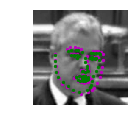

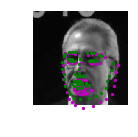

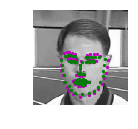

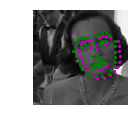

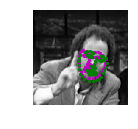

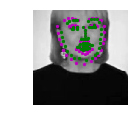

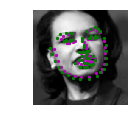

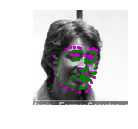

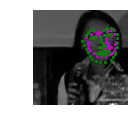

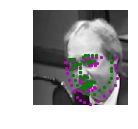

In [17]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [18]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_6.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


Answer: So coming to optimization i choose adam optimizer, because as far as i know it works well in computer vision task and deep learning model.because this algo takes momentum and rmsprop and put it back together(so fastly recover from local minima) 

i choose loss function because  Smooth L1-loss combination of of L1-loss and L2-loss(steady gradients for large values of x and less oscillations during updates when x is small).

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: So I started with 5x5 then 3x3 and based on that performation i decided to add convolutional layer and other layers  I could add more layers but it might be little complex for this environment because it does not support gpu

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: I started from 1 epoch than change to 5  and than 10 it took almost half a day without gpu. and result was not that much great so i gave up on high number of epoch and tried to change other parmeters to increase accuraacy.
i did change batch_size to 20 and than 32 but than i have to change num_workers to 0 as it gave error, so best result i gain from less number of batch size.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

In [ ]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

In [ ]:
##TODO: load in and display any image from the transformed test dataset
import cv2


image = test_images[1]
image = image.numpy().reshape(224,224)
print(image.shape)

plt.imshow(np.squeeze(image), cmap='gray')
plt.show()
## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

cd = cv2.filter2D(image, -1, w[1][0])
plt.imshow(cd, cmap='gray')





### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: i think it detectss edge of the image and detect the shape of object(face).

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!